<a href="https://colab.research.google.com/github/MiniSoda17/comp3710-deep-learning/blob/main/COMP3710_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.3 DawnBench


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# CIFAR-10 transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

# Datasets + Dataloaders
batch_size = 512
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_classes = len(classes)

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = None
        if stride != 1 or in_planes != planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)
    def _make_layer(self, planes, blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_planes, planes, stride))
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# def conv3x3(in_planes, out_planes, stride=1):
#     return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
#                      padding=1, bias=False)

# def conv1x1(in_planes, out_planes, stride=1):
#     return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

# class BasicBlock(nn.Module):
#     expansion = 1
#     def __init__(self, in_planes, planes, stride=1, dropout_rate=0.1):
#         super().__init__()
#         self.conv1 = conv3x3(in_planes, planes, stride)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.relu = nn.ReLU(inplace=True)
#         self.dropout1 = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()

#         self.conv2 = conv3x3(planes, planes)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.dropout2 = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()

#         self.downsample = None
#         if stride != 1 or in_planes != planes:
#             self.downsample = nn.Sequential(
#                 conv1x1(in_planes, planes, stride),
#                 nn.BatchNorm2d(planes)
#             )

#         # Improved weight initialization
#         self._init_weights()

#     def _init_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#         identity = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.dropout1(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.dropout2(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)
#         return out

# class ResNet18(nn.Module):
#     def __init__(self, num_classes=10, dropout_rate=0.1, use_mixup=False):
#         super().__init__()
#         self.in_planes = 64
#         self.use_mixup = use_mixup

#         # Enhanced initial conv with proper padding for CIFAR-10
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)

#         # ResNet layers with dropout
#         self.layer1 = self._make_layer(64, 2, stride=1, dropout_rate=dropout_rate)
#         self.layer2 = self._make_layer(128, 2, stride=2, dropout_rate=dropout_rate)
#         self.layer3 = self._make_layer(256, 2, stride=2, dropout_rate=dropout_rate)
#         self.layer4 = self._make_layer(512, 2, stride=2, dropout_rate=dropout_rate)

#         # Enhanced pooling and classification head
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.dropout = nn.Dropout(0.5)  # Stronger dropout before final layer
#         self.fc = nn.Linear(512, num_classes)

#         # Initialize weights
#         self._init_weights()

#     def _init_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, 0, 0.01)
#                 nn.init.constant_(m.bias, 0)

#     def _make_layer(self, planes, blocks, stride, dropout_rate=0.1):
#         layers = []
#         layers.append(BasicBlock(self.in_planes, planes, stride, dropout_rate))
#         self.in_planes = planes
#         for _ in range(1, blocks):
#             layers.append(BasicBlock(self.in_planes, planes, dropout_rate=dropout_rate))
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)

#         out = self.avgpool(out)
#         out = torch.flatten(out, 1)
#         out = self.dropout(out)
#         out = self.fc(out)
#         return out

# # Optional: Label Smoothing Loss for better generalization
# class LabelSmoothingCrossEntropy(nn.Module):
#     def __init__(self, smoothing=0.1):
#         super().__init__()
#         self.smoothing = smoothing

#     def forward(self, x, target):
#         confidence = 1. - self.smoothing
#         logprobs = F.log_softmax(x, dim=-1)
#         nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
#         nll_loss = nll_loss.squeeze(1)
#         smooth_loss = -logprobs.mean(dim=-1)
#         loss = confidence * nll_loss + self.smoothing * smooth_loss
#         return loss.mean()

# # Usage example:
# # model = ResNet18(num_classes=10, dropout_rate=0.1)
# # criterion = LabelSmoothingCrossEntropy(smoothing=0.1)  # Instead of nn.CrossEntropyLoss()


In [ ]:
model = ResNet18(num_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, epochs=40, steps_per_epoch=len(trainloader)
)
scaler = GradScaler()

num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(trainloader))

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%")

torch.save(model.state_dict(), "/content/drive/MyDrive/resnet18_cifar10.pth")
print("Target reached. Model saved!")



/tmp/ipython-input-3969628217.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/40:   0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipython-input-3969628217.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/40: 100%|██████████| 98/98 [00:05<00:00, 18.69it/s, loss=1.47]
/tmp/ipython-input-3969628217.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/40], Accuracy: 53.76%


Epoch 2/40: 100%|██████████| 98/98 [00:05<00:00, 18.08it/s, loss=1.04]


Epoch [2/40], Accuracy: 52.67%


Epoch 3/40: 100%|██████████| 98/98 [00:05<00:00, 18.60it/s, loss=0.832]


Epoch [3/40], Accuracy: 60.25%


Epoch 4/40: 100%|██████████| 98/98 [00:05<00:00, 17.96it/s, loss=0.714]


Epoch [4/40], Accuracy: 52.47%


Epoch 5/40: 100%|██████████| 98/98 [00:05<00:00, 18.35it/s, loss=0.62]


Epoch [5/40], Accuracy: 71.63%


Epoch 6/40: 100%|██████████| 98/98 [00:05<00:00, 18.02it/s, loss=0.573]


Epoch [6/40], Accuracy: 72.15%


Epoch 7/40: 100%|██████████| 98/98 [00:05<00:00, 17.91it/s, loss=0.507]


Epoch [7/40], Accuracy: 71.37%


Epoch 8/40: 100%|██████████| 98/98 [00:05<00:00, 18.61it/s, loss=0.461]


Epoch [8/40], Accuracy: 72.78%


Epoch 9/40: 100%|██████████| 98/98 [00:05<00:00, 18.53it/s, loss=0.422]


Epoch [9/40], Accuracy: 77.76%


Epoch 10/40: 100%|██████████| 98/98 [00:05<00:00, 18.42it/s, loss=0.385]


Epoch [10/40], Accuracy: 81.43%


Epoch 11/40: 100%|██████████| 98/98 [00:05<00:00, 18.42it/s, loss=0.354]


Epoch [11/40], Accuracy: 84.26%


Epoch 12/40: 100%|██████████| 98/98 [00:05<00:00, 18.22it/s, loss=0.326]


Epoch [12/40], Accuracy: 85.89%


Epoch 13/40: 100%|██████████| 98/98 [00:05<00:00, 18.61it/s, loss=0.293]


Epoch [13/40], Accuracy: 85.87%


Epoch 14/40: 100%|██████████| 98/98 [00:05<00:00, 18.13it/s, loss=0.261]


Epoch [14/40], Accuracy: 87.88%


Epoch 15/40: 100%|██████████| 98/98 [00:05<00:00, 18.45it/s, loss=0.243]


Epoch [15/40], Accuracy: 77.35%


Epoch 16/40: 100%|██████████| 98/98 [00:05<00:00, 18.48it/s, loss=0.219]


Epoch [16/40], Accuracy: 85.56%


Epoch 17/40: 100%|██████████| 98/98 [00:05<00:00, 18.40it/s, loss=0.205]


Epoch [17/40], Accuracy: 87.31%


Epoch 18/40: 100%|██████████| 98/98 [00:05<00:00, 18.76it/s, loss=0.185]


Epoch [18/40], Accuracy: 86.58%


Epoch 19/40: 100%|██████████| 98/98 [00:05<00:00, 18.61it/s, loss=0.169]


Epoch [19/40], Accuracy: 89.39%


Epoch 20/40: 100%|██████████| 98/98 [00:05<00:00, 18.67it/s, loss=0.147]


Epoch [20/40], Accuracy: 87.93%


Epoch 21/40: 100%|██████████| 98/98 [00:05<00:00, 18.52it/s, loss=0.136]


Epoch [21/40], Accuracy: 90.26%


Epoch 22/40: 100%|██████████| 98/98 [00:05<00:00, 18.70it/s, loss=0.128]


Epoch [22/40], Accuracy: 90.74%


Epoch 23/40: 100%|██████████| 98/98 [00:05<00:00, 18.26it/s, loss=0.108]


Epoch [23/40], Accuracy: 90.80%


Epoch 24/40: 100%|██████████| 98/98 [00:05<00:00, 18.55it/s, loss=0.0959]


Epoch [24/40], Accuracy: 90.27%


Epoch 25/40: 100%|██████████| 98/98 [00:05<00:00, 17.62it/s, loss=0.0883]


Epoch [25/40], Accuracy: 89.79%


Epoch 26/40: 100%|██████████| 98/98 [00:05<00:00, 18.16it/s, loss=0.073]


Epoch [26/40], Accuracy: 91.49%


Epoch 27/40: 100%|██████████| 98/98 [00:05<00:00, 18.44it/s, loss=0.0618]


Epoch [27/40], Accuracy: 91.64%


Epoch 28/40: 100%|██████████| 98/98 [00:05<00:00, 18.79it/s, loss=0.0519]


Epoch [28/40], Accuracy: 91.98%


Epoch 29/40: 100%|██████████| 98/98 [00:05<00:00, 18.44it/s, loss=0.0442]


Epoch [29/40], Accuracy: 92.51%


Epoch 30/40: 100%|██████████| 98/98 [00:05<00:00, 18.91it/s, loss=0.0355]


Epoch [30/40], Accuracy: 92.60%


Epoch 31/40: 100%|██████████| 98/98 [00:05<00:00, 18.40it/s, loss=0.0249]


Epoch [31/40], Accuracy: 93.01%


Epoch 32/40: 100%|██████████| 98/98 [00:05<00:00, 18.79it/s, loss=0.0196]


Epoch [32/40], Accuracy: 93.12%


Epoch 33/40: 100%|██████████| 98/98 [00:05<00:00, 18.65it/s, loss=0.0131]


Epoch [33/40], Accuracy: 93.20%


Epoch 34/40: 100%|██████████| 98/98 [00:05<00:00, 18.73it/s, loss=0.0116]


Epoch [34/40], Accuracy: 93.14%


Epoch 35/40: 100%|██████████| 98/98 [00:05<00:00, 18.68it/s, loss=0.00799]


Epoch [35/40], Accuracy: 93.38%


Epoch 36/40: 100%|██████████| 98/98 [00:05<00:00, 18.71it/s, loss=0.00719]


Epoch [36/40], Accuracy: 93.34%


Epoch 37/40: 100%|██████████| 98/98 [00:05<00:00, 18.52it/s, loss=0.0058]


Epoch [37/40], Accuracy: 93.54%


Epoch 38/40: 100%|██████████| 98/98 [00:05<00:00, 18.65it/s, loss=0.00508]


Epoch [38/40], Accuracy: 93.46%


Epoch 39/40: 100%|██████████| 98/98 [00:05<00:00, 18.83it/s, loss=0.00544]


Epoch [39/40], Accuracy: 93.48%


Epoch 40/40: 100%|██████████| 98/98 [00:05<00:00, 18.53it/s, loss=0.00477]


Epoch [40/40], Accuracy: 93.51%
Target reached. Model saved!


In [ ]:
model = ResNet18(num_classes=n_classes).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/resnet18_cifar10.pth", map_location=device))
print("Pretrained model loaded!")


Pretrained model loaded!


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scaler = GradScaler()

num_epochs = 1  # demo only
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Demo Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(trainloader))

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Demo Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%")


/tmp/ipython-input-3507590684.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Demo Epoch 1/1:   0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipython-input-3507590684.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Demo Epoch 1/1: 100%|██████████| 98/98 [00:05<00:00, 18.48it/s, loss=0.0196]
/tmp/ipython-input-3507590684.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Demo Epoch [1/1], Accuracy: 92.99%


# 4.1 VAE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

In [ ]:
class CNNVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 28 -> 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 14 -> 7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 7 -> 4
            nn.ReLU(),
            nn.Flatten(),
        )

        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128*4*4)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),   # 16 -> 32
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder_conv(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std if self.training else mu

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 128, 4, 4)
        return self.decoder_conv(h)[:, :, :28, :28]  # crop to 28×28

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss averaged per pixel
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x, reduction="sum"
    ) / x.size(0)  # divide by batch size

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    return BCE + beta * KLD, BCE, KLD



In [ ]:
# --- Data Loading ---
class OASISDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # The glob.glob function finds all files matching a pattern
        # The '**' and 'recursive=True' find images in all subdirectories
        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.png'), recursive=True)
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('L') # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image

# Define transformations to resize and convert images to tensors
transformations = transforms.Compose([
    transforms.Resize((28, 28)), # Resize to 28x28
    transforms.ToTensor(),       # Convert to a PyTorch tensor (values between 0 and 1)
])

# Define paths on the Rangpur cluster
data_path = '/content/drive/My Drive/OASIS'
train_dir = os.path.join(data_path, 'keras_png_slices_train')
test_dir = os.path.join(data_path, 'keras_png_slices_test')

# Create a dataset and a data loader for the training data
train_dataset = OASISDataset(root_dir=train_dir, transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
# --- Training Loop ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = CNNVAE(latent_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 50 # Increase this for better results

print("Starting VAE training...")

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss, _, _ = vae_loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item() / len(data):.4f}')

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch: {epoch+1}, Average Loss: {avg_loss:.4f}')

print("Training complete.")
torch.save(model.state_dict(), 'vae_oasis.pth')

Using device: cuda
Starting VAE training...
Epoch: 1, Average Loss: 2.1184
Epoch: 2, Average Loss: 1.7126
Epoch: 3, Average Loss: 1.7014
Epoch: 4, Average Loss: 1.6925
Epoch: 5, Average Loss: 1.6842
Epoch: 6, Average Loss: 1.6758
Epoch: 7, Average Loss: 1.6672
Epoch: 8, Average Loss: 1.6643
Epoch: 9, Average Loss: 1.6628
Epoch: 10, Average Loss: 1.6617
Epoch: 11, Average Loss: 1.6609
Epoch: 12, Average Loss: 1.6606
Epoch: 13, Average Loss: 1.6599
Epoch: 14, Average Loss: 1.6593
Epoch: 15, Average Loss: 1.6592
Epoch: 16, Average Loss: 1.6590
Epoch: 17, Average Loss: 1.6589
Epoch: 18, Average Loss: 1.6587
Epoch: 19, Average Loss: 1.6586
Epoch: 20, Average Loss: 1.6587
Epoch: 21, Average Loss: 1.6585
Epoch: 22, Average Loss: 1.6584
Epoch: 23, Average Loss: 1.6585
Epoch: 24, Average Loss: 1.6586
Epoch: 25, Average Loss: 1.6582
Epoch: 26, Average Loss: 1.6583
Epoch: 27, Average Loss: 1.6580
Epoch: 28, Average Loss: 1.6583
Epoch: 29, Average Loss: 1.6582
Epoch: 30, Average Loss: 1.6581
Epoch

Generating latent space visualization by sampling with random background latents...


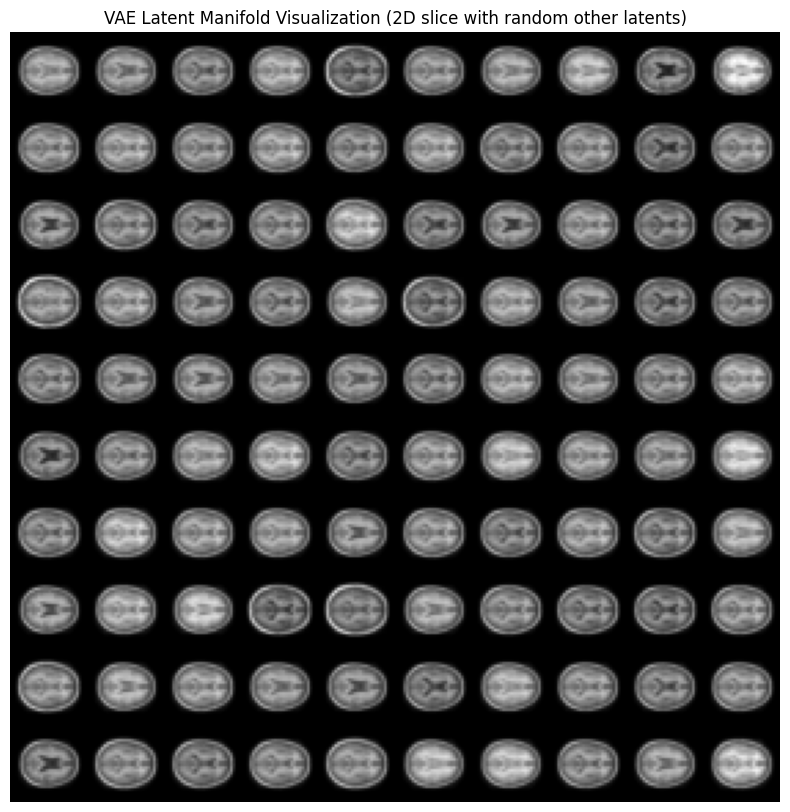

Generating latent space visualization using UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


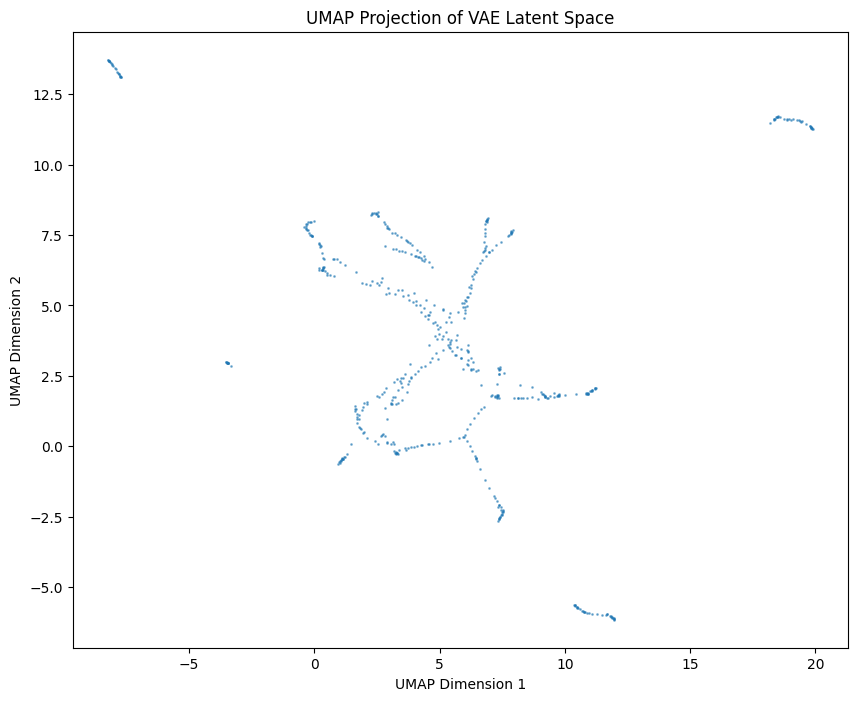

In [ ]:
# --- Latent Manifold Visualization (Sampling with Randomized Latents) ---
model.eval()
print("Generating latent space visualization by sampling with random background latents...")

# Create a 2D sampling grid from two latent dimensions
n = 10  # Number of images per row/column
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

figure = np.zeros((28 * n, 28 * n))
latent_dim = 32

# Choose which two latent dims to visualize
dim1, dim2 = 0, 1

with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # Sample a random latent vector from N(0, I)
            z = torch.randn(1, latent_dim).to(device)

            # Override the two dimensions we want to visualize
            z[0, dim1] = xi
            z[0, dim2] = yi

            reconstruction = model.decode(z).cpu()

            # Handle decoder output shape safely
            img = reconstruction.squeeze().numpy()
            if img.ndim == 3:  # e.g. (C, H, W)
                img = img[0]  # take first channel if grayscale

            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.title('VAE Latent Manifold Visualization (2D slice with random other latents)')
plt.axis('off')
plt.savefig('vae_manifold_sampling_random.png')
plt.show()

# --- Latent Manifold Visualization (UMAP) ---
print("Generating latent space visualization using UMAP...")

# Load test dataset
test_dataset = OASISDataset(root_dir=test_dir, transform=transformations)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Collect latent vectors
latents = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        mu, _ = model.encode(data)  # encode returns (mu, logvar)
        latents.append(mu.cpu().numpy())

# Stack all latent vectors
latents = np.concatenate(latents, axis=0)

# Standardize before UMAP
latents = StandardScaler().fit_transform(latents)

# Reduce dimensionality to 2 with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(latents)

# Plot the embedding
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=1, alpha=0.5)
plt.title("UMAP Projection of VAE Latent Space")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.savefig("vae_manifold_umap.png")
plt.show()


# 4.2 UNET

In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Cell 1: Setup, Imports, and Google Drive Mounting

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle



print("✅ Setup Complete. TensorFlow Version:", tf.__version__)

In [ ]:
# Cell 1.5: Copy and Extract Data Locally

print("🚀 Copying data from Drive to local Colab runtime...")
# This single copy is MUCH faster than thousands of small reads
!cp /content/drive/MyDrive/OASIS/OASIS_png.zip /content/

print("✅ Copy complete. Extracting files...")
# Extracting on the local disk is lightning fast
!unzip -q /content/OASIS_png.zip -d /content/

print("✅ Extraction complete. Data is now ready on the local disk!")

In [ ]:
# Cell 2: Configuration and Data Loading

# --- Configuration ---
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1 # The MRI scans are grayscale
NUM_CLASSES = 4 # 0: Background, 1: CSF, 2: Gray Matter, 3: White Matter

# --- Paths to Dataset in Google Drive ---
# IMPORTANT: Make sure this base_path points to your OASIS folder
base_path = '/content/'

train_img_dir = os.path.join(base_path, 'keras_png_slices_train')
train_mask_dir = os.path.join(base_path, 'keras_png_slices_seg_train')
val_img_dir = os.path.join(base_path, 'keras_png_slices_validate')
val_mask_dir = os.path.join(base_path, 'keras_png_slices_seg_validate')
test_img_dir = os.path.join(base_path, 'keras_png_slices_test')
test_mask_dir = os.path.join(base_path, 'keras_png_slices_seg_test')


def load_and_preprocess_data(image_dir, mask_dir, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Loads images and masks, remaps mask values, normalizes images,
    resizes them, and one-hot encodes masks.
    """
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load and resize image
        img = Image.open(img_path).convert('L')
        img = img.resize(target_size)
        images.append(np.array(img))

        # Load and resize mask
        mask = Image.open(mask_path).convert('L')
        mask = mask.resize(target_size, resample=Image.NEAREST)
        mask_np = np.array(mask)

        # --- THIS IS THE FIX ---
        # Remap the pixel values from [0, 85, 170, 255] to [0, 1, 2, 3]
        mask_np[mask_np == 85] = 1
        mask_np[mask_np == 170] = 2
        mask_np[mask_np == 255] = 3
        # ----------------------

        masks.append(mask_np)

    # Convert to numpy arrays and normalize images
    images_np = np.array(images) / 255.0
    masks_np = np.array(masks)

    # Add channel dimension for grayscale images
    images_np = np.expand_dims(images_np, axis=-1)

    # One-hot encode the masks as required
    masks_cat = to_categorical(masks_np, num_classes=NUM_CLASSES)

    return images_np, masks_cat

# Load all datasets
print("⏳ Loading training data...")
X_train, y_train = load_and_preprocess_data(train_img_dir, train_mask_dir)
print(f"✅ Training data loaded. Images shape: {X_train.shape}, Masks shape: {y_train.shape}")

print("\n⏳ Loading validation data...")
X_val, y_val = load_and_preprocess_data(val_img_dir, val_mask_dir)
print(f"✅ Validation data loaded. Images shape: {X_val.shape}, Masks shape: {y_val.shape}")

print("\n⏳ Loading test data...")
X_test, y_test = load_and_preprocess_data(test_img_dir, test_mask_dir)
print(f"✅ Test data loaded. Images shape: {X_test.shape}, Masks shape: {y_test.shape}")

In [ ]:
# Cell 4: Training the Model

# --- Callbacks ---
# Save the best model based on validation Dice coefficient
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_brain_mri_unet.keras',
    monitor='val_dice_coef',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Stop training early if there's no improvement
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_dice_coef',
    patience=10, # Number of epochs with no improvement to wait
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# --- Train the model ---
print("\n🚀 Starting model training...")
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50, # Set a higher number, EarlyStopping will handle it
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint, early_stopping],
    shuffle=True
)
print("✅ Model training finished.")

In [ ]:
# Cell 5: Evaluation and Visualization

# --- Load the best model for evaluation ---
# Note: EarlyStopping with restore_best_weights=True already loaded the best weights into the 'model' object.
# If you were running this in a separate script, you'd load the saved file like this:
# model = tf.keras.models.load_model(
#     'best_brain_mri_unet.keras',
#     custom_objects={'dice_coef': dice_coef}
# )

print("\n📊 Evaluating model on the test set...")
test_loss, test_dsc = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🎉 Test Set Dice Similarity Coefficient (DSC): {test_dsc:.4f}")
print(f"📉 Test Set Loss: {test_loss:.4f}")

# --- Visualization of Results ---
def visualize_segmentation(model, images, true_masks, num_samples=5):
    """
    Visualizes the original image, true mask, and predicted mask for a few samples.
    """
    # Get predictions from the model
    predictions = model.predict(images)

    # Convert one-hot encoded data back to single-channel label maps for visualization
    true_labels = np.argmax(true_masks, axis=-1)
    predicted_labels = np.argmax(predictions, axis=-1)

    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title("Original MRI Slice")
        plt.imshow(images[i, :, :, 0], cmap='gray')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title("Ground Truth Segmentation")
        plt.imshow(true_labels[i], cmap='viridis')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.title(f"Predicted Segmentation")
        plt.imshow(predicted_labels[i], cmap='viridis')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Select a few random samples from the test set to visualize
sample_indices = np.random.choice(len(X_test), size=5, replace=False)

print("\n🖼️ Displaying segmentation results for 5 random test images...")
visualize_segmentation(
    model,
    X_test[sample_indices],
    y_test[sample_indices]
)

# 4.3 GAN